In [1]:
from typing import List

from dataset import UserGraphDataset
from dataset_in_memory import fetch_question_ids
from hetero_GAT import HeteroGAT
import torch
import re
import os

2023-04-16 16:49:22 INFO     PostEmbedding instantiated!


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2023-04-16 16:49:33 INFO     Proceeding with cpu . .
HIII


In [2]:
# Load model (EXP 1)
model = HeteroGAT(out_channels=2, num_layers=3, hidden_channels=64)
model.load_state_dict(torch.load('../models/SAGE_3l_60e_64h.pt', map_location=torch.device('cpu')), strict=False)
model.eval()

HeteroGAT(
  (convs): ModuleList(
    (0): HeteroConv(num_relations=10)
    (1): HeteroConv(num_relations=10)
    (2): HeteroConv(num_relations=10)
  )
  (lin1): Linear(3392, 64, bias=True)
  (lin2): Linear(64, 2, bias=True)
  (softmax): Softmax(dim=-1)
)

In [3]:
question_ids = fetch_question_ids("../data")
train_ids = list(question_ids)[:int(len(question_ids) * 0.7)]
test_ids = [x for x in question_ids if x not in train_ids]
# Instantiate the dataset class for access to database
ugd = UserGraphDataset(root='../data/', db_address='../stackoverflow.db', skip_processing=True)

2023-04-16 16:49:34 INFO     PostEmbedding instantiated!


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def fetch_answer_files(question_id: int):
    for f in os.listdir('../data/processed/'):
        question_id_search = re.search(r"id_(\d+)", f)
        if question_id_search:
            if int(question_id_search.group(1)) == question_id:
                yield torch.load(os.path.join('../data/processed/', f))

In [5]:
"""
TODO:
For each question-answer pair, predict, and measure distribution of topic tags for each answer.
This will be used to identify topics which the model is most confident about.
"""

'\nTODO:\nFor each question-answer pair, predict, and measure distribution of topic tags for each answer.\nThis will be used to identify topics which the model is most confident about.\n'

In [6]:
from tqdm import tqdm
from torch_geometric.loader import DataLoader

correct_tag_count = {}
incorrect_tag_count = {}

# DEBUG START
tag_question_ids = {}
# DEBUG END

tag_predictions = {}

for i in tqdm(test_ids):
    graph_files = list(fetch_answer_files(i))
    dataloader = DataLoader(graph_files, batch_size=1, shuffle=False)

    # Fetch tags for question
    tags = [x for x in ugd.fetch_tags_for_question(i) if x != 'python']

    for answer, graph in zip(ugd.fetch_answers_for_question(i).itertuples(), dataloader):

        post_emb = torch.cat([graph.question_emb, graph.answer_emb], dim=1)
        out = model(graph.x_dict, graph.edge_index_dict, graph.batch_dict, post_emb)  # Perform a single forward pass.
        pred = out.argmax(dim=1)  # Use the class with highest probability.


        if len(tags) == 0:
            tags = ['python']

        for tag in tags:
            # DEBUG START
            if tag not in tag_question_ids:
                tag_question_ids[tag] = [i]
            else:
                tag_question_ids[tag].append(i)
            # DEBUG END

            if tag not in tag_predictions:
                tag_predictions[tag] = ([pred.item()], [graph.label.item()])
            else:
                tag_predictions[tag][0].append(pred.item())
                tag_predictions[tag][1].append(graph.label.item())

            if pred == graph.label:
                if tag in correct_tag_count:
                    correct_tag_count[tag] += 1
                else:
                    correct_tag_count[tag] = 1
            else:
                if tag in incorrect_tag_count:
                    incorrect_tag_count[tag] += 1
                else:
                    incorrect_tag_count[tag] = 1



100%|██████████| 2126/2126 [22:26<00:00,  1.58it/s]


In [7]:
# DEBUG START
# Pickle the tag_question_ids dict
import pickle
with open('../data/raw/tag_question_ids.pickle', 'wb') as handle:
    pickle.dump(tag_question_ids, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
correct_tag_count

{'datetime': 132,
 'strptime': 6,
 'easy-install': 9,
 'pip': 6,
 'python': 616,
 'django': 628,
 'django-models': 106,
 'django-managers': 2,
 'list': 369,
 'multithreading': 71,
 'pyqt': 24,
 'unit-testing': 75,
 'exception': 100,
 'tuples': 24,
 'redirect': 17,
 'stderr': 7,
 'sql': 47,
 'django-queryset': 19,
 'django-aggregation': 1,
 'git': 7,
 'githooks': 3,
 'random': 88,
 'lisp': 23,
 'clojure': 5,
 'idioms': 59,
 'coding-style': 44,
 'conventions': 7,
 'algorithm': 117,
 'sorting': 56,
 'file': 111,
 'loops': 64,
 'subprocess': 115,
 'stdout': 11,
 'popen': 10,
 'sqlalchemy': 50,
 'insert': 8,
 'portability': 5,
 'java': 60,
 'ruby': 106,
 'user-interface': 60,
 'cross-platform': 34,
 'string': 363,
 'path': 105,
 'logging': 74,
 'amazon-web-services': 6,
 'boto': 10,
 'wxpython': 46,
 'distribution': 3,
 'freeze': 2,
 'c++': 85,
 'swfupload': 2,
 'split': 29,
 'text-segmentation': 3,
 'pypi': 16,
 'garbage-collection': 7,
 'attributes': 16,
 'object': 79,
 'python-3.x': 141,

In [9]:
incorrect_tag_count

{'datetime': 77,
 'strptime': 4,
 'user-interface': 58,
 'qt': 20,
 'pyqt': 27,
 'python': 638,
 'django': 636,
 'django-models': 87,
 'django-managers': 2,
 'list': 421,
 'multithreading': 86,
 'unit-testing': 62,
 'exception': 61,
 'tuples': 43,
 'redirect': 19,
 'stderr': 2,
 'sql': 44,
 'django-queryset': 12,
 'django-aggregation': 1,
 'lisp': 26,
 'clojure': 6,
 'idioms': 41,
 'algorithm': 165,
 'sorting': 48,
 'file': 122,
 'loops': 81,
 'subprocess': 40,
 'stdout': 12,
 'popen': 13,
 'sqlalchemy': 39,
 'insert': 10,
 'portability': 16,
 'java': 91,
 'ruby': 112,
 'cross-platform': 29,
 'string': 286,
 'path': 56,
 'logging': 48,
 'amazon-web-services': 3,
 'boto': 5,
 'wxpython': 38,
 'distribution': 12,
 'freeze': 5,
 'c++': 105,
 'swfupload': 1,
 'split': 45,
 'text-segmentation': 6,
 'pypi': 8,
 'garbage-collection': 1,
 'attributes': 14,
 'object': 53,
 'python-3.x': 76,
 'character': 8,
 'numpy': 58,
 'scipy': 41,
 'statistics': 16,
 'posix': 5,
 'django-templates': 79,
 'a

In [10]:
tag_predictions

{'datetime': ([1,
   0,
   1,
   1,
   0,
   1,
   1,
   0,
   1,
   0,
   0,
   1,
   0,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   0,
   1,
   0,
   1,
   0,
   0,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   0,
   1,
   0,
   1,
   1,
   1,
   0,
   1,
   0,
   0,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   0,
   1,
   1,
   0,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   0,
   1,
   0,
   1,
   0,
   1,
   0,
   0,
   1,
   1,
   0,
   1,
   0,
   0,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   0,
   1,
   1,
   0,
   1,
   0,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   0,
   1,
   1,
   1

In [11]:
from sklearn.metrics import f1_score, accuracy_score

rows = []

for tag, (true, labels) in tag_predictions.items():
    rows.append((tag, f1_score(true, labels, average='binary'), accuracy_score(true, labels), len(true) + len(labels)))

In [12]:
import pandas as pd
results = pd.DataFrame(rows, columns=['tag', 'f1', 'accuracy', 'count'])
results.sort_values(by='f1', ascending=False)

,tag,f1,accuracy,count
908,feedparser,1.0,1.00,2
219,version,1.0,1.00,10
99,spring,1.0,1.00,6
1090,captcha,1.0,1.00,4
1091,recaptcha,1.0,1.00,4
...,...,...,...,...
738,python-2.7,0.0,0.25,8
337,windows-7-x64,0.0,0.50,20
129,tree-structure,0.0,0.00,14
1047,mta,0.0,0.00,6


In [13]:
top_15 = results.sort_values(by='f1', ascending=False)[results['count'] > 10].head(15)
top_15

C:\Users\liamb\AppData\Local\Temp\ipykernel_17348\1473026940.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_15 = results.sort_values(by='f1', ascending=False)[results['count'] > 10].head(15)


,tag,f1,accuracy,count
1029,setup.py,1.000000,1.000000,20
1030,python-packaging,1.000000,1.000000,20
421,celery,1.000000,1.000000,12
939,deque,1.000000,1.000000,14
282,command,0.984127,0.969697,132
389,ansi-colors,0.976000,0.953125,128
590,output,0.970149,0.942029,138
223,identifier,0.969697,0.941176,34
281,terminal,0.961240,0.927536,276
151,temporary-files,0.960000,0.928571,28


In [14]:
bottom_15 = results.sort_values(by='f1', ascending=False)[results['count'] > 15].tail(20).sort_values(by='count', ascending=False)
bottom_15

C:\Users\liamb\AppData\Local\Temp\ipykernel_17348\2240084834.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bottom_15 = results.sort_values(by='f1', ascending=False)[results['count'] > 15].tail(20).sort_values(by='count', ascending=False)


,tag,f1,accuracy,count
192,primes,0.0,0.533333,90
202,large-files,0.0,0.214286,28
946,rename,0.0,0.142857,28
947,batch-rename,0.0,0.142857,28
964,reverse-lookup,0.0,0.384615,26
1058,digits,0.0,0.090909,22
665,sysadmin,0.0,0.090909,22
866,matrix,0.0,0.181818,22
669,sudoku,0.0,0.090909,22
376,data-migration,0.0,0.200000,20


[Text(5, 0, '20'),
 Text(5, 0, '20'),
 Text(5, 0, '12'),
 Text(5, 0, '14'),
 Text(5, 0, '132'),
 Text(5, 0, '128'),
 Text(5, 0, '138'),
 Text(5, 0, '34'),
 Text(5, 0, '276'),
 Text(5, 0, '28'),
 Text(5, 0, '46'),
 Text(5, 0, '22'),
 Text(5, 0, '22'),
 Text(5, 0, '94'),
 Text(5, 0, '38')]

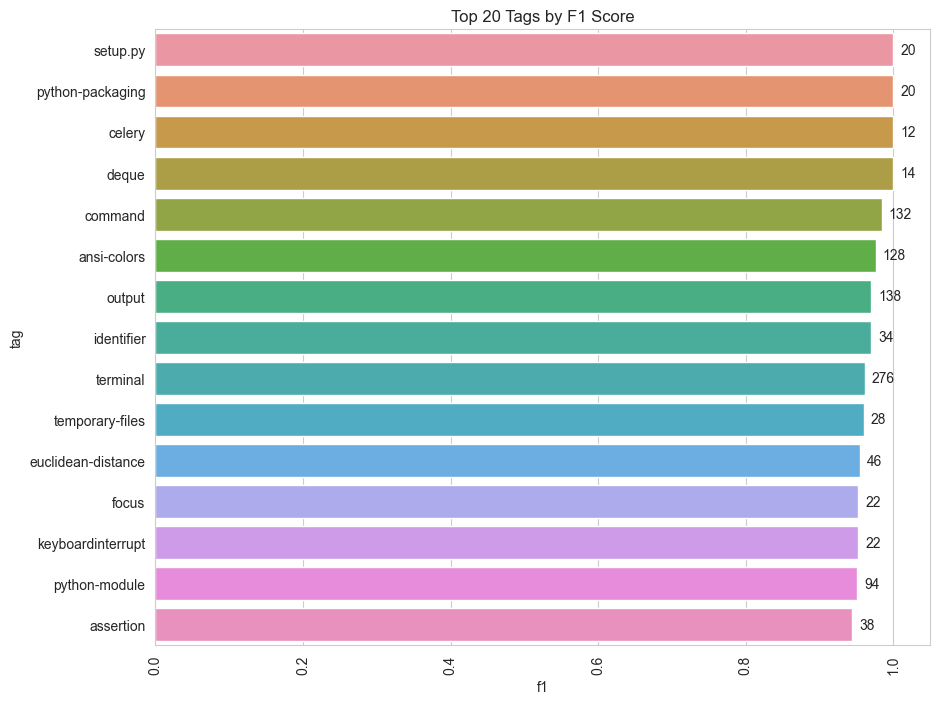

In [15]:
import seaborn as sns
sns.color_palette("muted")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
ax = sns.barplot(y=top_15['tag'], x=top_15['f1'])
plt.xticks(rotation=90)
plt.title('Top 20 Tags by F1 Score')
# Label with counts
ax.bar_label(ax.containers[0], labels=top_15['count'], padding=5)

[Text(5, 0, '90'),
 Text(5, 0, '28'),
 Text(5, 0, '28'),
 Text(5, 0, '28'),
 Text(5, 0, '26'),
 Text(5, 0, '22'),
 Text(5, 0, '22'),
 Text(5, 0, '22'),
 Text(5, 0, '22'),
 Text(5, 0, '20'),
 Text(5, 0, '20'),
 Text(5, 0, '18'),
 Text(5, 0, '18'),
 Text(5, 0, '18'),
 Text(5, 0, '18'),
 Text(5, 0, '16'),
 Text(5, 0, '16'),
 Text(5, 0, '16'),
 Text(5, 0, '16'),
 Text(5, 0, '16')]

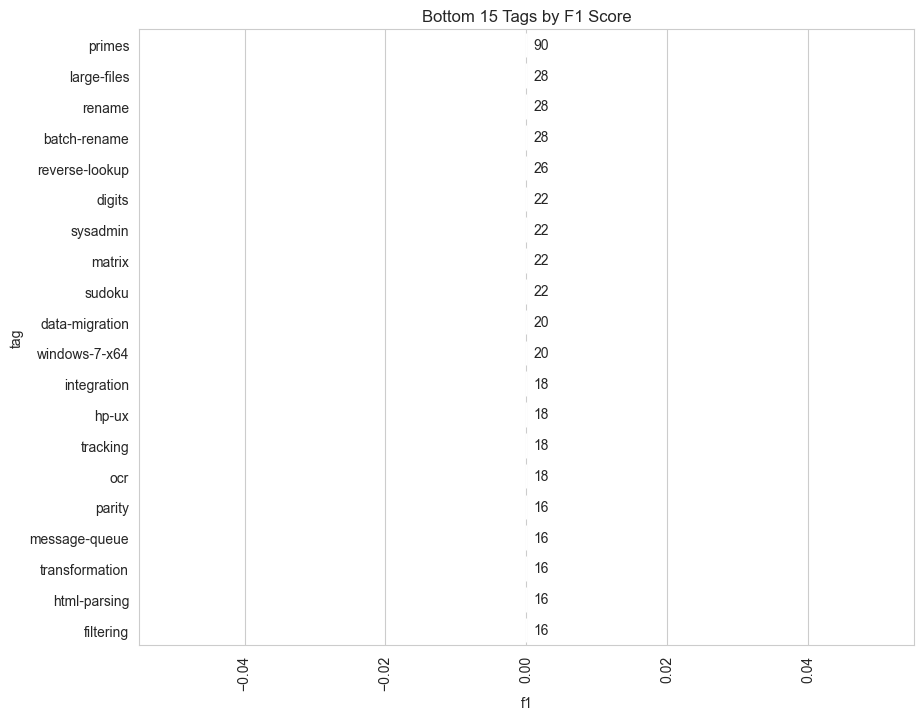

In [16]:
plt.figure(figsize=(10, 8))
ax = sns.barplot(y=bottom_15['tag'], x=bottom_15['f1'])
plt.xticks(rotation=90)
plt.title('Bottom 15 Tags by F1 Score')
# Label with counts
ax.bar_label(ax.containers[0], labels=bottom_15['count'], padding=5)